In [711]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [712]:
#Загружаем все необходимые библиотеки

from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

In [713]:
# Загружаем исходные данные
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [714]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [715]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requiremnts.txt

# Общая информация о датасете

In [716]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [717]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [718]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [719]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [720]:
sample_submission.sample(5)

,client_id,default
14480,66634,0.359372
1257,72691,0.660544
8681,53232,0.630453
19303,64443,0.396319
6483,68550,0.035267


In [721]:
# Для корректной обработки данных объединим train и test в один датасет
train['sample'] = 1 # помечаем train
test['sample'] = 0 # помечаем test
test['default'] = 0 # значения дефолта отсутствуют для тестовой выборки, то заполним нулями

data = test.append(train, sort=False).reset_index(drop=True)

# Обработка NAN

In [722]:
data.sample(15)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
82425,29158,05FEB2014,GRD,M,27,N,N,1,0,-2.087794,0,60,2,3,30000,4,3,N,1,0
105846,79624,27MAR2014,GRD,M,31,N,N,0,1,-1.915726,2,80,2,3,35000,4,4,N,1,0
33573,18153,25JAN2014,SCH,M,27,N,N,0,1,-1.694834,2,80,2,3,20000,2,3,N,0,0
59444,6453,13JAN2014,GRD,M,66,N,N,0,0,-2.082826,0,40,2,3,39000,4,1,N,1,0
74356,86245,02APR2014,SCH,F,37,N,N,0,0,-2.250712,0,40,1,3,32000,1,3,Y,1,0
55739,103898,22APR2014,UGR,M,21,N,N,0,1,-1.471019,0,80,2,3,35000,1,1,N,1,0
80825,75980,24MAR2014,GRD,M,24,N,N,1,0,-1.703829,4,50,2,3,22000,2,3,Y,1,0
66276,104771,23APR2014,GRD,M,44,Y,Y,0,0,-2.216469,11,60,2,3,400000,1,4,N,1,0
64297,64831,13MAR2014,GRD,M,37,Y,Y,0,1,-2.325459,1,80,2,3,70000,1,4,N,1,0
7880,13811,21JAN2014,SCH,M,57,Y,N,0,0,-1.613615,0,60,2,3,167000,1,3,N,0,0


In [723]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Как мы видим, пустые значения есть только в колонке education. Исходя из общего количества строк в датасете (110148), можно просто удалить строки, содержащие пустые значения. Однако также можно попробовать заменить их на моду данного столбца.

Пойдем по второму пути.

In [724]:
data['education'].value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [725]:
data['education'] = data['education'].fillna(data['education'].value_counts().index[0])

In [726]:
data['education'].value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

# Категориальные, бинарные, числовые признаки

In [727]:
# Найдём бинарные данные

for col in data.columns:
    if train[col].nunique() <= 2:
        print(col, " ", data[col].nunique())

sex   2
car   2
car_type   2
good_work   2
foreign_passport   2
sample   2
default   2


In [728]:
# Для более удобной работы создадим списки по категориям датасета (категориальные, бинарные, числовые)

bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'app_date', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

# EDA

Визуализируем признаки

In [729]:
#посмотрим общую информацию по всем признакам
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


Посмотрим корреляцию

<AxesSubplot:>

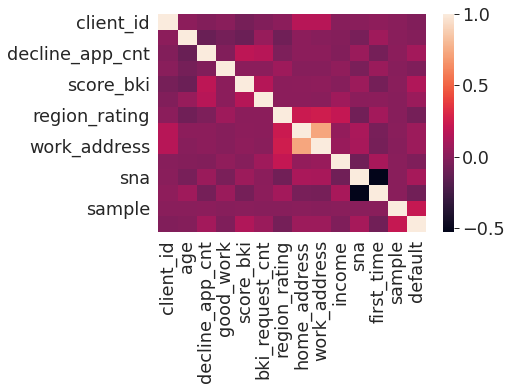

In [730]:
sn.heatmap(data.corr())

In [731]:
data.corr()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
client_id,1.000000,0.015535,-0.021508,0.003447,-0.061653,-0.027428,0.005720,0.163686,0.163422,-0.002069,-0.001624,0.016865,0.002844,-0.030812
age,0.015535,1.000000,-0.111454,-0.072233,-0.104682,0.046975,-0.089147,0.012135,-0.004509,-0.018664,-0.058364,0.078644,0.003864,-0.019169
decline_app_cnt,-0.021508,-0.111454,1.000000,-0.029525,0.187869,0.159927,-0.038254,0.011095,0.015410,-0.022241,0.062434,-0.070939,0.004536,0.092455
good_work,0.003447,-0.072233,-0.029525,1.000000,0.005063,0.007789,0.070839,-0.008650,-0.011993,0.026447,-0.052889,0.058787,-0.002376,-0.035126
score_bki,-0.061653,-0.104682,0.187869,0.005063,1.000000,0.157451,0.007132,0.016056,0.016683,-0.011721,0.067646,-0.069805,-0.000538,0.139777
bki_request_cnt,-0.027428,0.046975,0.159927,0.007789,0.157451,1.000000,0.006780,0.005331,0.001763,0.080475,0.004577,0.012247,-0.002931,0.061523
region_rating,0.005720,-0.089147,-0.038254,0.070839,0.007132,0.006780,1.000000,0.232971,0.254062,0.207494,-0.080876,0.090701,-0.002780,-0.071729
home_address,0.163686,0.012135,0.011095,-0.008650,0.016056,0.005331,0.232971,1.000000,0.726535,0.037882,0.114541,-0.058430,0.001525,0.068008
work_address,0.163422,-0.004509,0.015410,-0.011993,0.016683,0.001763,0.254062,0.726535,1.000000,0.052153,0.111162,-0.062266,-0.003287,0.064733
income,-0.002069,-0.018664,-0.022241,0.026447,-0.011721,0.080475,0.207494,0.037882,0.052153,1.000000,-0.090882,0.109453,0.002735,-0.031735


<AxesSubplot:>

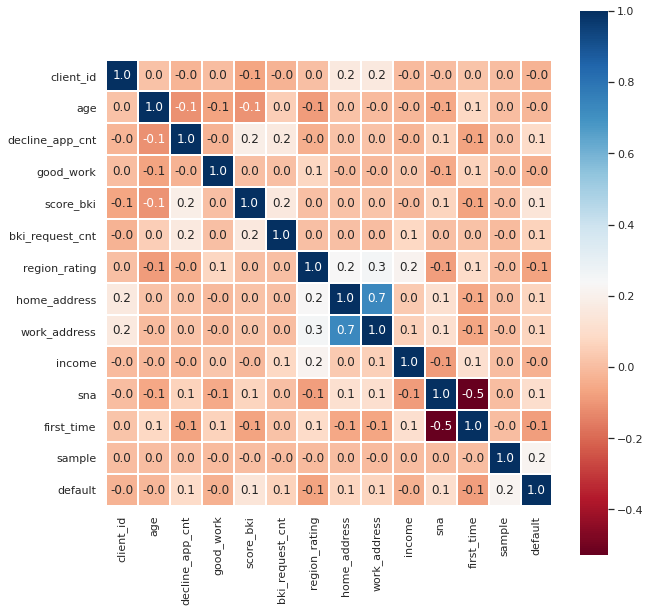

In [732]:
sn.set(font_scale=1)
plt.subplots(figsize=(10, 10))
sn.heatmap(data.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Есть видимая корелляция между home_address и work_address. Возможно в дальнейшем потребуется преобразовать данные признаки.  Между sna (связь заёмщика с клиентами банка) и first_time(первое обращение в банк) тоже видна корреляци, но она относительно незначительна

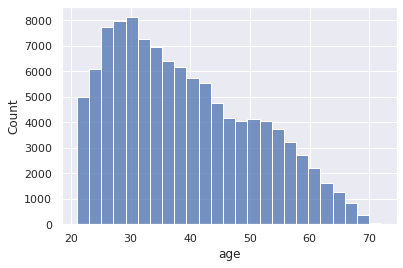

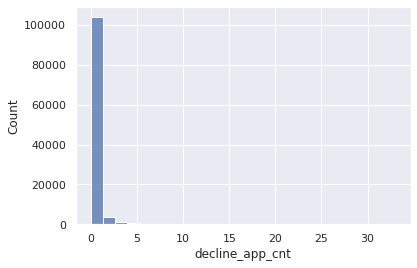

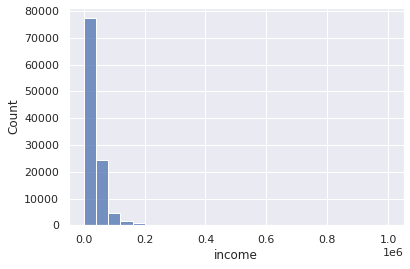

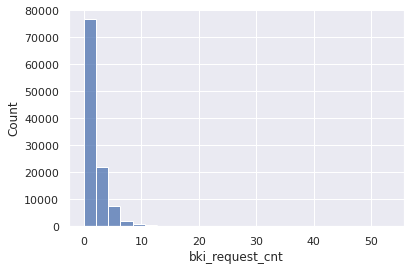

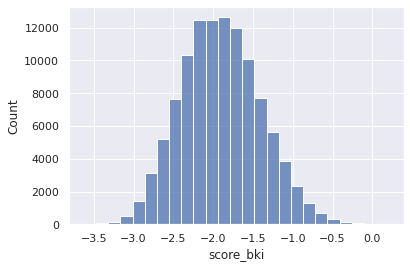

In [733]:
for col in num_cols:
    sn.histplot(data[col], cbar=True, bins = 25)
    plt.show()

По данным графикам можно сделать вывод, что по некоторым признакам (inome, age, bki_request_cnt, decline_app_cnt) распределения не являются нормальными и смещены вправо. При построении модели необходимо будет нормализовать их.

In [734]:
data['income'].value_counts(bins=10)

(0.999, 100900.0]        105488
(100900.0, 200800.0]       3607
(200800.0, 300700.0]        656
(300700.0, 400600.0]        171
(400600.0, 500500.0]        106
(500500.0, 600400.0]         43
(900100.0, 1000000.0]        25
(600400.0, 700300.0]         22
(700300.0, 800200.0]         17
(800200.0, 900100.0]         13
Name: income, dtype: int64

Видно, что по большой части доходы людей деражтся в пределах 100000, но убирать тех, у кого доход выше, будет неправильно,так как исказит нашу модель

10.752880921895006


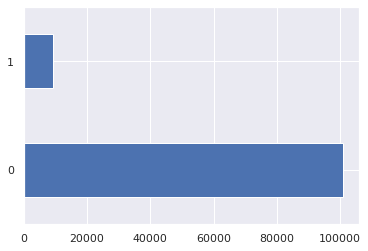

In [735]:
data['default'].value_counts().plot.barh()
print(len(data[data['default']==0])/len(data[data['default']==1]))

Как мы можем видеть, клиенты без дефолта преобладают нам клиентами с дефолтом почти в 11 раз. Датасет несбалансирован, что может привести к проблемам при построение модели

<AxesSubplot:>

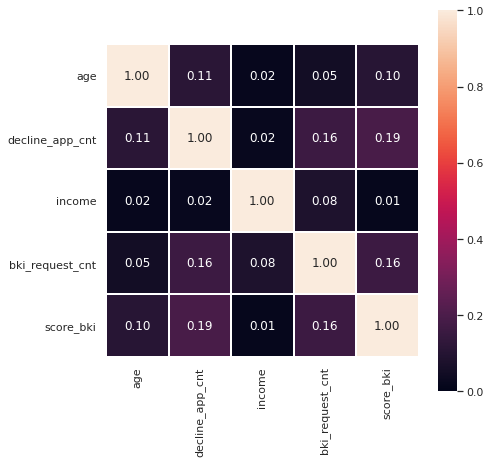

In [736]:
# Посмотрим матрицу коэффициента корреляции численных признаков
sn.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sn.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1)

Исходя из данной матрицы корреляции видно, что признаки между собой скореллированы слабо. Поэтому оставим их все для модели.

Посмотрим распределение целевой переменной числовых признаков

<AxesSubplot:>

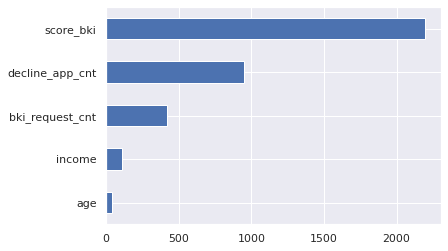

In [737]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Скоринговый балл по данным из БКИ (score_bki) является одним из самых значимых числовых признаков

**Поработаем с датой**

In [738]:
data.app_date

0         22MAR2014
1         24JAN2014
2         23MAR2014
3         03FEB2014
4         04FEB2014
            ...    
110143    04MAR2014
110144    24MAR2014
110145    22APR2014
110146    04JAN2014
110147    23JAN2014
Name: app_date, Length: 110148, dtype: object

Полное исследование признака показывает, что определенные влияние на целевой признак оказывает только месяц. Остальные части даты вовсе не играют никакой роли для результата. Поэтому оставляем только значения месяца.

In [739]:
# Преобразуем дату, оставляя только месяц
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date'] = data['app_date'].apply(lambda x: x.month)

In [740]:
data.app_date

0         3
1         1
2         3
3         2
4         2
         ..
110143    3
110144    3
110145    4
110146    1
110147    1
Name: app_date, Length: 110148, dtype: int64

In [741]:
# Переведем дату в катеогрию "численные"
cat_cols.remove('app_date')
num_cols.append('app_date')

Посмотрим распределение целевой переменной обновлённых числовых признаков

<AxesSubplot:>

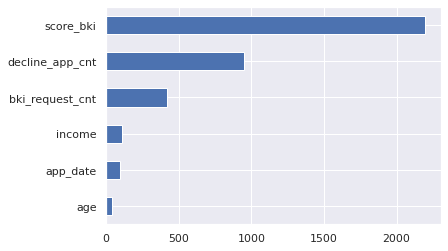

In [742]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Преобразование бинарных признаков

In [743]:
# Преобразуем бинарные признаки с помощью LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
data.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
53367,30790,2,SCH,1,49,0,0,1,0,-1.474903,0,60,1,2,60000,1,3,0,1,0
91408,43795,2,SCH,1,42,0,0,0,0,-1.803948,0,60,2,2,35000,1,4,0,1,0
87461,37463,2,SCH,1,42,0,0,0,0,-1.879857,0,50,1,2,10000,1,4,0,1,0
95315,2017,1,SCH,0,62,0,0,0,0,-1.921511,3,40,1,1,67000,1,3,0,1,0
76045,68858,3,SCH,1,29,0,0,1,1,-1.883121,3,50,2,2,40000,1,3,0,1,0
60266,45917,2,SCH,1,54,0,0,0,0,-2.365797,6,50,1,1,150000,2,4,0,1,0
35825,100695,4,GRD,0,61,0,0,0,0,-2.906978,0,50,2,3,13000,4,1,0,0,0
108005,49787,2,SCH,0,26,0,0,0,0,-1.745543,8,80,2,3,25000,1,4,0,1,0
91390,110019,4,UGR,0,66,0,0,0,0,-1.831064,2,40,2,3,12000,1,4,0,1,0
16615,46089,2,SCH,0,37,0,0,0,0,-1.388858,3,60,1,3,22000,3,2,0,0,0


Посмотрим распределение целевой переменной бинарных признаков

<AxesSubplot:>

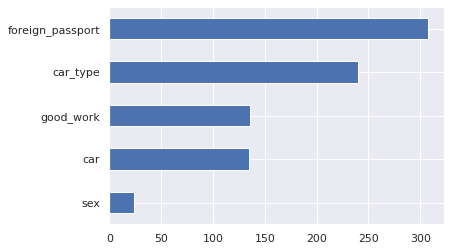

In [744]:
imp_bin = pd.Series(f_classif(data[bin_cols], data['default'])[0], index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

<AxesSubplot:>

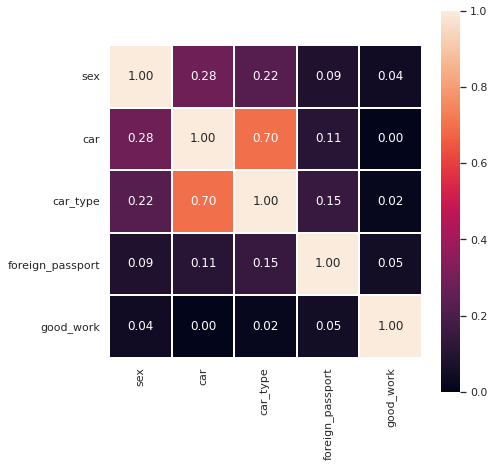

In [745]:
# Посмотрим матрицу коэффициента корреляции бинарных признаков
sn.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sn.heatmap(data[bin_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1)

Есть видимая корелляция между car и car_type, можно в дальнейшим объединить эти признаки


# Преобразование категориальных признаков

In [746]:
# преобразуем education в числовой вид
data['education'] = data['education'].astype('category').cat.reorder_categories(
    ['SCH', 'GRD', 'UGR', 'PGR', 'ACD']).cat.codes

Посмотрим распределение целевой переменной категориальных признаков

<AxesSubplot:>

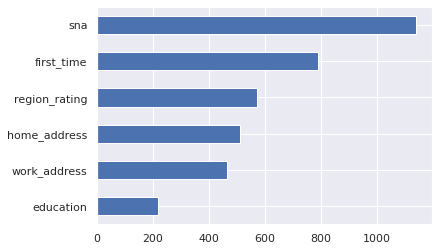

In [747]:
imp_cat = pd.Series(f_classif(data[cat_cols], data['default'])[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Feature engeenering

Согласно коэффициенту корреляции между home_address и work_address, а также car и car_type достаточно сильная связь. Мы объединим эти признаки в один

In [748]:
# Объединяем признаки home_address и work_address в новый признак addresses:

# Чтобы не было одинаковых результатов при 
    #складывние разных исходных(2+2 = 3+1 = 4) домножаем один из признаков на 10
def unification_adr(row):

    result = 10*row['home_address'] + row['work_address'] 
    return result

  
data['addresses'] = data.apply(lambda row: unification_adr(row), axis=1)
cat_cols.append('addresses')

cat_cols.remove('home_address')
data.drop(['home_address'], axis=1, inplace=True)

cat_cols.remove('work_address')
data.drop(['work_address'], axis=1, inplace=True)

In [749]:
# Объединяем признаки car и car_type в один признак car_type:

def unification_car(row):

    result = row['car'] + row['car_type'] 
    return result

# В итоге получаем: если 0, то машины нет, если 1 - то есть отечественная, 
    #если 2 - то есть иномарка

data['car_type'] = data.apply(lambda row: unification_car(row), axis=1)

bin_cols.remove('car')

bin_cols.remove('car_type')
cat_cols.append('car_type')

data.drop(['car'], axis=1, inplace=True)

In [750]:
data.head(15)

,client_id,app_date,education,sex,age,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,sample,default,addresses
0,74835,3,1,1,29,2.0,0,0,-2.271884,3,50,50000,1,4,0,0,0,12.0
1,17527,1,0,0,39,0.0,5,0,-1.504999,2,50,5000,4,3,0,0,0,12.0
2,75683,3,2,1,50,2.0,0,0,-1.691339,1,50,30000,1,3,1,0,0,12.0
3,26883,2,0,1,56,0.0,0,0,-2.374182,1,40,17000,1,3,0,0,0,12.0
4,28862,2,1,0,38,0.0,0,0,-2.487502,0,80,120000,1,3,0,0,0,23.0
5,99881,4,0,0,55,0.0,0,0,-1.740224,7,50,30000,2,1,0,0,0,33.0
6,26630,2,0,0,30,0.0,3,0,-1.387847,5,60,11000,4,3,0,0,0,12.0
7,79934,3,1,1,41,2.0,0,0,-3.066047,3,60,80000,4,1,0,0,0,13.0
8,16605,1,1,1,34,0.0,0,0,-3.117086,0,80,5000,1,2,0,0,0,23.0
9,105449,4,2,1,28,2.0,0,0,-2.185172,0,80,80000,1,3,1,0,0,23.0


Посмотрим распределение целевой переменной обновлённых категориальных признаков 

<AxesSubplot:>

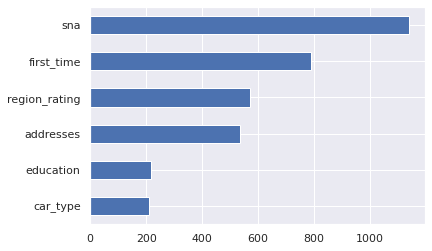

In [751]:
imp_cat = pd.Series(f_classif(data[cat_cols], data['default'])[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [752]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  int64  
 2   education         110148 non-null  int8   
 3   sex               110148 non-null  int64  
 4   age               110148 non-null  int64  
 5   car_type          110148 non-null  float64
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  income            110148 non-null  int64  
 12  sna               110148 non-null  int64  
 13  first_time        110148 non-null  int64  
 14  foreign_passport  110148 non-null  int64  
 15  sample            110148 non-null  int64  
 16  default           11

# Построение модели


In [753]:
# Преобразуем категориальные признаки с помощью get_dummies
data = pd.get_dummies(data, columns=cat_cols)

In [754]:
# выполним стандартизацию численных переменных
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]),
                              columns=num_cols)

In [755]:
# Разделим обратно на train и test
train = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)

In [756]:
# удалим для X целевую переменную и client_id
X = train.drop(columns = ['default', 'client_id'])
Y = train['default']

In [757]:
# Разделим выборку на train и test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED,
                                                    test_size=0.2)

In [758]:
# Обучаем модель:

model_0 = LogisticRegression(solver = 'liblinear', max_iter = 1000)
model_0.fit(X_train, Y_train)
y_pred = model_0.predict(X_test)

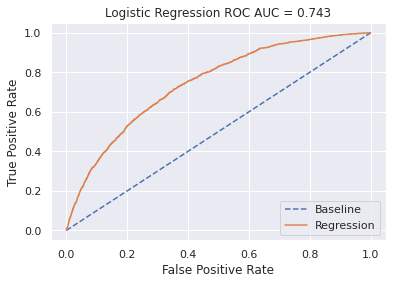

In [759]:
# Logistic Regression ROC AUC:

probs = model_0.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

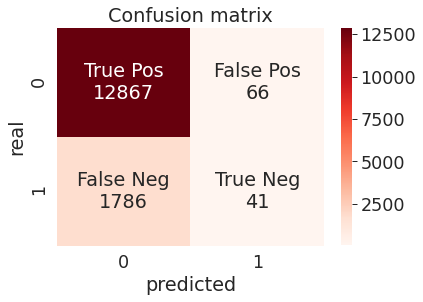

In [760]:
# Confusion matrix:

sn.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sn.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Reds')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Модель логистической регрессии имеет достаточно высокую точность, однако, оценив матрицу ошибок, мы видим, что модель хорошо предсказывает недефолтных клиентов, но очень плохо - дефолтных.

In [761]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.8745
f1_score: 0.0424
recall_score: 0.0224
MSE: 0.1255


Такой перекос в показаниях модели, может быть последствием того, что в исходном датасете данные несбалансированные. Можно попробовать выполнить undersampling, то есть случайным образом уменьшить преобладающий класс в столько раз, во сколько он превосходит другой класс

6.874413145539906


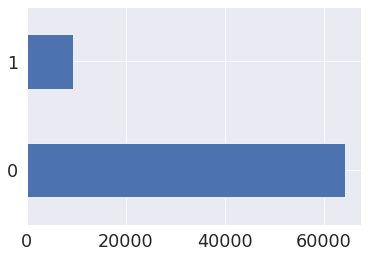

In [762]:
train['default'].value_counts().plot.barh()
print(len(train[train['default']==0])/len(train[train['default']==1]))

Разница почти в 7 раз

In [763]:
# Выберем случайным образом из train['default']==0 такое количество строк, которое
# равнялось бы train['default']==1, и затем объединим с train['default']==1.
under_train = pd.concat([train[train['default']==0].sample(
    len(train[train['default']==1]), random_state=RANDOM_SEED), train[train['default']==1]])

X = under_train.drop(columns = ['default', 'client_id'])
Y = under_train['default']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED,
                                                    test_size=0.2)

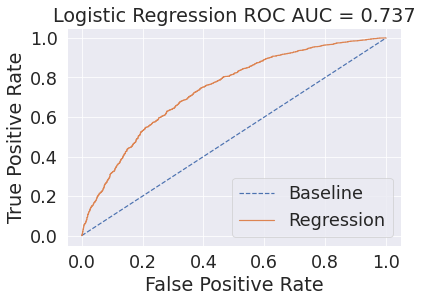

In [764]:

model_0 = LogisticRegression(solver = 'liblinear', max_iter = 1000)
model_0.fit(X_train, Y_train)
y_pred = model_0.predict(X_test)

# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

probs = model_0.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [765]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))


accuracy_score: 0.6756
f1_score: 0.6768
recall_score: 0.6837
MSE: 0.3244


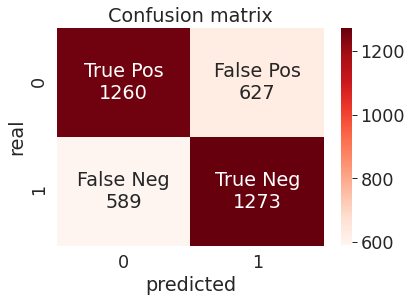

In [766]:
# Визуализация confusion matrix:
sn.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sn.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Reds')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

ROC AUC почти не изменился. Но модель стала лучше предсказывать класс TrueNegative.

CATBOOST

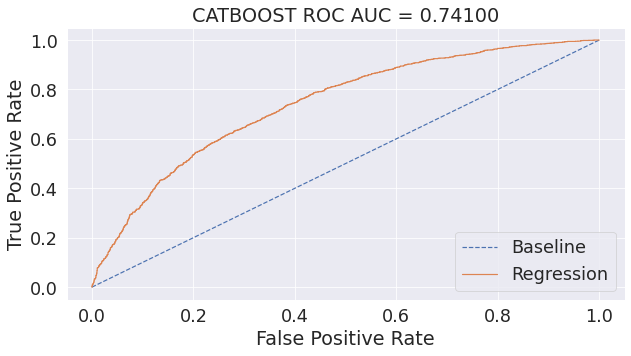

In [767]:
# CATBOOST
catbst = CatBoostClassifier(
                        n_estimators=1000,
                        depth=2,
                        logging_level='Silent')
catbst.fit(X_train, Y_train)
probs = catbst.predict_proba(X_test)
y_pred = catbst.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('CATBOOST ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')


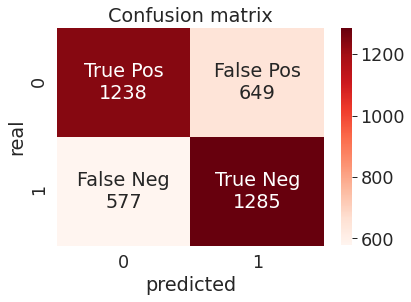

In [768]:
# Визуализация confusion matrix:
sn.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sn.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Reds')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

In [769]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.673
f1_score: 0.677
recall_score: 0.6901
MSE: 0.327


Две последнии модели, практически идентичны, подгрузим в сабмит catboost

In [770]:
X_test2 = test.drop(columns = ['default', 'client_id'])
y_probs = catbst.predict_proba(X_test2)[:,1]
test['default'] = y_probs
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

,client_id,default
34651,104043,0.345284
13928,20014,0.532853
13777,102373,0.426902
19499,29175,0.760215
21114,68400,0.543519
25272,26699,0.628888
32478,43045,0.377716
35553,27394,0.593226
30036,23603,0.803401
14280,64906,0.379163


(36349, 2)